In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pylab as pl
import sys,h5py,urllib,zipfile
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

Using TensorFlow backend.


## One Neuron

In [0]:
# functions for neuron construction
def sigmoid(x): return 1.0/(1+np.exp(-x))
def sigmoid_derivation(x): return x*(1.0-x)

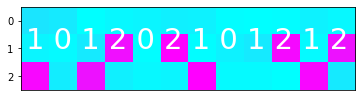

In [3]:
# artificial data for the experiment
X=np.array([[.11,.05,.95],[.09,.03,.08],[.01,.09,.91],
            [.04,.92,.07],[.05,.02,.04],[.07,.97,.05],
            [.06,.02,.98],[.02,.06,.03],[.01,.09,.03],
            [.02,.94,.01],[.06,.03,.95],[.04,.91,.09]])
Y=np.array([[1,0,1,2,0,2,1,0,1,2,1,2]]).T
pl.imshow(X.T,cmap=pl.cm.cool); pl.xticks([])
pl.text(-.3,1,str(Y.T)[2:-2],c='white',fontsize=29);

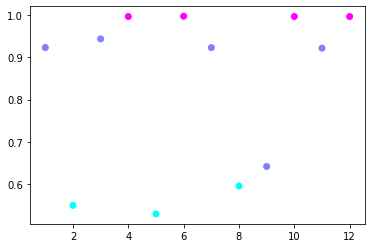

In [4]:
# the start point for iterations
synapse0=np.random.randn(3,1); layer0=X
# the steps of iteration
for iter in range(100):
    layer1=sigmoid(np.dot(layer0,synapse0))
    # finding errors and directions for correction
    layer1_error=layer1-Y
    layer1_delta=layer1_error*sigmoid_derivation(layer1)
    # correction values & coefficients
    synapse0_derivative=np.dot(layer0.T,layer1_delta)
    synapse0-=synapse0_derivative
pl.scatter(list(range(1,13)),layer1,c=Y,cmap=pl.cm.cool);

[[0.11  0.05  0.95  1.    0.923 1.   ]
 [0.09  0.03  0.08  0.    0.55  0.   ]
 [0.01  0.09  0.91  1.    0.943 1.   ]
 [0.04  0.92  0.07  2.    0.996 2.   ]
 [0.05  0.02  0.04  0.    0.53  0.   ]
 [0.07  0.97  0.05  2.    0.997 2.   ]
 [0.06  0.02  0.98  1.    0.923 1.   ]
 [0.02  0.06  0.03  0.    0.596 0.   ]
 [0.01  0.09  0.03  1.    0.642 0.   ]
 [0.02  0.94  0.01  2.    0.996 2.   ]
 [0.06  0.03  0.95  1.    0.921 1.   ]
 [0.04  0.91  0.09  2.    0.996 2.   ]]


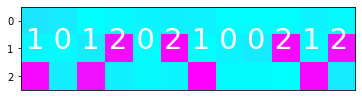

In [5]:
# comparing predictions and real data
# the error in the start labeling (the 9th image) had been corrected
def labeling(x):
    if (x<.7): return 0
    if (x>.7) and (x<.99): return 1
    else: return 2
predict_Y=np.array([[labeling(layer1[i,0]) for i in range(12)]]).T
pl.imshow(X.T,cmap=pl.cm.cool); pl.xticks([])
pl.text(-.3,1,str(predict_Y.T)[2:-2],c='white',fontsize=29)
print(np.hstack((np.hstack((X,Y)),
                (layer1.round(3)),(predict_Y))))

## One Simple NN (MLP)

In [0]:
class NeuralNetMLP(object):
    def __init__(self,n_output,n_features,n_hidden=30,
                 l1=0.0,l2=0.0,epochs=500,eta=.001, 
                 alpha=0.0,decrease_const=0.0,shuffle=True, 
                 minibatches=1,random_state=None):
        np.random.seed(random_state)
        self.n_output=n_output; self.n_features=n_features
        self.n_hidden=n_hidden; self.epochs=epochs
        self.w1,self.w2=self._initialize_weights()
        self.l1=l1; self.l2=l2; self.eta=eta; self.alpha=alpha
        self.decrease_const=decrease_const
        self.shuffle=shuffle
        self.minibatches=minibatches
    def _encode_labels(self,y,k):
        onehot=np.zeros((k,y.shape[0]))
        for idx,val in enumerate(y):
            onehot[val,idx]=1.
        return onehot
    def _initialize_weights(self):
        w1=np.random.uniform(-1.0,1.0,
                             size=self.n_hidden*(self.n_features+1))
        w1=w1.reshape(self.n_hidden,self.n_features+1)        
        w2=np.random.uniform(-1.0,1.0,
                             size=self.n_output*(self.n_hidden+1))
        w2=w2.reshape(self.n_output,self.n_hidden+1)        
        return w1,w2
    def _sigmoid(self,z): return 1.0/(1.0+np.exp(-z))
    def _sigmoid_gradient(self,z):
        sg=self._sigmoid(z)
        return sg*(1-sg)
    def _add_bias_unit(self,X,how='column'):
        if how=='column':
            X_new=np.ones((X.shape[0],X.shape[1]+1))
            X_new[:,1:]=X
        elif how=='row':
            X_new=np.ones((X.shape[0]+1,X.shape[1]))
            X_new[1:,:]=X
        else:
            mes='`how` must be `column` or `row`'
            raise AttributeError(mes)
        return X_new
    def _feedforward(self,X,w1,w2):
        a1=self._add_bias_unit(X,how='column')
        z2=w1.dot(a1.T)
        a2=self._sigmoid(z2)
        a2=self._add_bias_unit(a2,how='row')
        z3=w2.dot(a2)
        a3=self._sigmoid(z3)
        return a1,z2,a2,z3,a3
    def _L2_reg(self,lambda_,w1,w2):
        return (lambda_/2.0)*(np.sum(w1[:,1:]**2)+\
                              np.sum(w2[:,1:]**2))
    def _L1_reg(self,lambda_,w1,w2):
        return (lambda_/2.0)*(np.abs(w1[:,1:]).sum()+\
                              np.abs(w2[:,1:]).sum())
    def _get_cost(self,y_enc,output,w1,w2):
        term1=-y_enc*(np.log(output))
        term2=(1-y_enc)*np.log(1-output)
        cost=np.sum(term1-term2)
        L1_term=self._L1_reg(self.l1,w1,w2)
        L2_term=self._L2_reg(self.l2,w1,w2)
        cost=cost+L1_term+L2_term
        return cost
    def _get_gradient(self,a1,a2,a3,z2,y_enc,w1,w2):
        sigma3=a3-y_enc
        z2=self._add_bias_unit(z2,how='row')
        sigma2=w2.T.dot(sigma3)*self._sigmoid_gradient(z2)
        sigma2=sigma2[1:,:]
        grad1=sigma2.dot(a1); grad2=sigma3.dot(a2.T)
        grad1[:,1:]+=(w1[:,1:]*(self.l1+self.l2))
        grad2[:,1:]+=(w2[:,1:]*(self.l1+self.l2))
        return grad1,grad2
    def predict(self,X):
        a1,z2,a2,z3,a3=self._feedforward(X,self.w1,self.w2)
        y_pred=np.argmax(z3,axis=0)
        return y_pred
    def fit(self,X,y,print_progress=False):
        self.cost_=[]; X_data,y_data=X.copy(),y.copy()
        y_enc=self._encode_labels(y,self.n_output)
        delta_w1_prev=np.zeros(self.w1.shape)
        delta_w2_prev=np.zeros(self.w2.shape)
        for i in range(self.epochs):
            self.eta/=(1+self.decrease_const*i)
            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d'%(i+1,self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                idx=np.random.permutation(y_data.shape[0])
                X_data,y_enc=X_data[idx],y_enc[:,idx]
            mini=np.array_split(range(y_data.shape[0]),self.minibatches)            
            for idx in mini:
                a1,z2,a2,z3,a3=self._feedforward(X_data[idx],
                                                 self.w1,self.w2)
                cost=self._get_cost(y_enc=y_enc[:,idx],
                                    output=a3,w1=self.w1,w2=self.w2)                
                self.cost_.append(cost)
                grad1,grad2=self._get_gradient(a1=a1,a2=a2,a3=a3,z2=z2,
                                               y_enc=y_enc[:,idx],
                                               w1=self.w1,w2=self.w2)
                delta_w1,delta_w2=self.eta*grad1,self.eta*grad2
                self.w1-=(delta_w1+(self.alpha*delta_w1_prev))
                self.w2-=(delta_w2+(self.alpha*delta_w2_prev))
                delta_w1_prev,delta_w2_prev=delta_w1,delta_w2
        return self

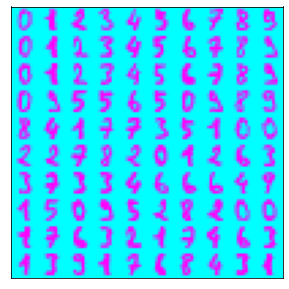

In [6]:
digits=datasets.load_digits(n_class=10)
X1,y1=digits.data,digits.target
X_train1,X_test1,y_train1,y_test1=\
train_test_split(X1,y1,test_size=.2,random_state=1)
img=np.zeros((100,100))
for i in range(10):
    ix=10*i+1
    for j in range(10):
        iy=10*j+1
        img[ix:ix+8,iy:iy+8]=X1[i*10+j].reshape((8,8))
pl.figure(figsize=(5,5))
pl.imshow(img,cmap=pl.cm.cool)
pl.xticks([]); pl.yticks([]);

In [8]:
nn1=NeuralNetMLP(n_output=10,n_features=X1.shape[1], 
                 n_hidden=128,l2=.1,l1=0.0,epochs=1000, 
                 eta=.01,alpha=.01,decrease_const=.001,
                 shuffle=True,minibatches=128,random_state=0)
nn1.fit(X_train1,y_train1,print_progress=True);

Epoch: 1000/1000

In [9]:
py_train1=nn1.predict(X_train1)
train_accuracy1=np.sum(y_train1==py_train1,
                       axis=0)/len(y_train1)
print('Digits. Train accuracy: %.2f%%'%(train_accuracy1*100))
py_test1=nn1.predict(X_test1)
test_accuracy1=np.sum(y_test1==py_test1,
                      axis=0)/len(y_test1)
print('Digits. Test accuracy: %.2f%%'%(test_accuracy1*100))

Digits. Train accuracy: 99.72%
Digits. Test accuracy: 98.61%


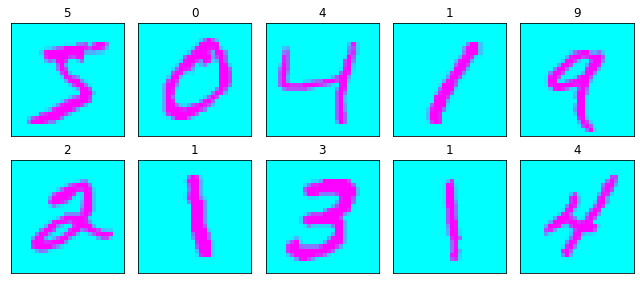

In [12]:
(X_train2,y_train2),(X_test2,y_test2)=mnist.load_data()
fig,ax=pl.subplots(figsize=(9,4),nrows=2,ncols=5,
                   sharex=True,sharey=True)
ax=ax.flatten()
for i in range(10):
    ax[i].imshow(X_train2[i],cmap=pl.cm.cool)
    ax[i].set_title(y_train2[i])
ax[0].set_xticks([]); ax[0].set_yticks([])
pl.tight_layout()

In [13]:
nn2=NeuralNetMLP(n_output=10,n_features=784, 
                 n_hidden=196,l2=.01,l1=0.0,epochs=1000, 
                 eta=.001,alpha=.001,decrease_const=.00001,
                shuffle=True,minibatches=50,random_state=1)
nn2.fit(X_train2.reshape(-1,784),y_train2,print_progress=True);

Epoch: 1000/1000

MNIST. Train accuracy: 98.83%
MNIST. Test accuracy: 96.81%


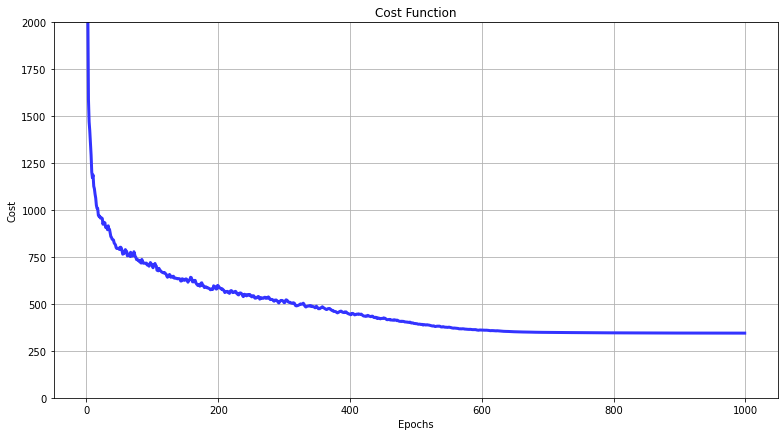

In [14]:
py_train2=nn2.predict(X_train2.reshape(-1,784))
train_accuracy2=np.sum(y_train2==py_train2,
                       axis=0)/len(y_train2)
print('MNIST. Train accuracy: %.2f%%'%(train_accuracy2*100))
py_test2=nn2.predict(X_test2.reshape(-1,784))
test_accuracy2=np.sum(y_test2==py_test2,
                      axis=0)/len(y_test2)
print('MNIST. Test accuracy: %.2f%%'%(test_accuracy2*100))
batches=np.array_split(range(len(nn2.cost_)),1000)
cost_ar=np.array(nn2.cost_)
cost_avg=[np.mean(cost_ar[i]) for i in batches]
pl.figure(figsize=(11,6))
pl.plot(range(len(cost_avg)),cost_avg,lw=3,color='#3333ff')
pl.xlabel('Epochs'); pl.ylim([0,2000]); pl.ylabel('Cost')
pl.tight_layout(); pl.grid(); pl.title('Cost Function');

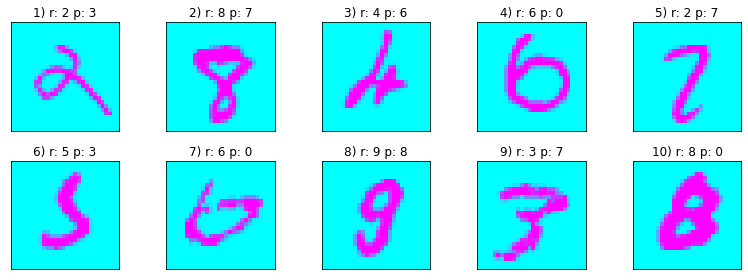

In [15]:
wrong_labeled=X_test2[y_test2!=py_test2][:15]
correct_labels=y_test2[y_test2!=py_test2][:15]
wrong_labels=py_test2[y_test2!=py_test2][:15]
fig,ax=pl.subplots(nrows=2,ncols=5,sharex=True,
                   sharey=True,figsize=(11,4))
ax=ax.flatten()
for i in range(10):
    image=wrong_labeled[i].reshape(28,28)
    ax[i].imshow(image,cmap=pl.cm.cool)
    l=(i+1,correct_labels[i],wrong_labels[i])
    ax[i].set_title('%d) r: %d p: %d'%l)
ax[0].set_xticks([]); ax[0].set_yticks([])
pl.tight_layout();

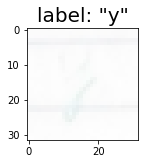

In [17]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); rn=10**3
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
X3=np.array(f[keys[1]])/255
#X3=np.dot(X3[...,:3],[.299,.587,.114])
y3=np.array(f[keys[2]])-1
X_train3,X_test3,y_train3,y_test3=\
train_test_split(X3,y3,test_size=.2,random_state=1)
pl.figure(figsize=(2,3))
pl.title('label: "%s"'%letters[y3[rn]],
         fontsize=20)
pl.imshow(X3[rn],cmap=pl.cm.cool);

In [18]:
nn3=NeuralNetMLP(n_output=33,n_features=3072, 
                 n_hidden=512,l2=.01,l1=0.0,epochs=1000, 
                 eta=.001,alpha=.001,decrease_const=.00001,
                 shuffle=True,minibatches=64,random_state=1)
nn3.fit(X_train3.reshape(-1,3072),y_train3,print_progress=True);

Epoch: 1000/1000

In [19]:
py_train3=nn3.predict(X_train3.reshape(-1,3072))
train_accuracy3=np.sum(y_train3==py_train3,
                       axis=0)/len(y_train3)
print('Letters. Train accuracy: %.2f%%'%(train_accuracy3*100))
py_test3=nn3.predict(X_test3.reshape(-1,3072))
test_accuracy3=np.sum(y_test3==py_test3,
                      axis=0)/len(y_test3)
print('Letters. Test accuracy: %.2f%%'%(test_accuracy3*100))

Letters. Train accuracy: 63.51%
Letters. Test accuracy: 54.47%
